# VAE using the reparametrization trick

## Import TensorFlow and enable Eager execution

In [1]:
import json
from collections import namedtuple
import warnings
import os
import time
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import imageio
from IPython import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from functional import seq
from pathlib import Path
from functools import reduce

from importlib import reload # for debugging and developing, optional

import tensorflow as tf
import tensorflow_probability as tfp
tfe = tf.contrib.eager
tfc = tf.contrib
tf.enable_eager_execution()
tfe.seterr(inf_or_nan='raise')
tfk = tf.keras
tfkl = tf.keras.layers

warnings.filterwarnings('ignore', '.*FutureWarning.*np.complexfloating.*')

from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_
import som_vae.helpers.tensorflow as tf_helpers
sess = tf.InteractiveSession(config=_TF_DEFAULT_SESSION_CONFIG_)
tf.keras.backend.set_session(sess)

from som_vae import settings
from som_vae import preprocessing
from som_vae.helpers.misc import extract_args, chunks, foldl
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.settings import data as SD
from som_vae.helpers import video, plots, misc, jupyter
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging

W0528 17:40:58.647377 140705393211200 lazy_loader.py:50] 
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0528 17:40:58.649937 140705393211200 deprecation_wrapper.py:119] From /home/samuel/SOM-VAE/som_vae/helpers/tensorflow.py:5: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [2]:
jupyter.fix_layout()

## Constants

In [3]:
# all those experiments and data will be used
from som_vae.settings import config
print(f"this is the main experiment, study, and fly id: {config.full_experiment_id()}.\n\nloadable experiments. there is a blacklist below.")
!ls $config.__EXPERIMENT_ROOT__

this is the main experiment, study, and fly id: 180920_aDN_CsCh-001_SG1-Fly2.

loadable experiments. there is a blacklist below.
180918_MDN_CsCh  180919_MDN_CsCh  180920_MDN_CsCh  180921_MDN_PR
180918_MDN_PR	 180919_MDN_PR	  180920_MDN_PR    181220_Rpr_R57C10_GC6s_tdTom
180919_aDN_CsCh  180920_aDN_CsCh  180921_aDN_CsCh
180919_aDN_PR	 180920_aDN_PR	  180921_aDN_PR


In [4]:
# if you want to see the flys as well, or just more information
# !tree -L 2 $config.__EXPERIMENT_ROOT__

In [5]:
_EXPERIMENT_BLACK_LIST_ = ['181220_Rpr_R57C10_GC6s_tdTom'] # all other experiments are used
_FLY_BLACK_LIST_ = ['180920_aDN_PR-Fly2-005_SG1', '180921_aDN_CsCh-Fly6-003_SG1'] # for those flys the angle conversion give odd results,
                                                                                  # and their distributions seem way off compared to the others)


_DATA_TYPE_3D_ANGLE_ = '3d_angle'
_DATA_TYPE_2D_POS_ = '2d_pos'
_SUPPORTED_DATA_TYPES_ = [_DATA_TYPE_3D_ANGLE_, _DATA_TYPE_2D_POS_]

run_config = {
    'debug': False,                 # general flag for debug mode, triggers all `d_.*`-options.
    'd_zero_data': False,          # overwrite the data with zeroed out data, the overall shape is kept.
    'd_sinoid_data': True, 
    'd_no_compression': False,     # if true, the latent_space will be the same dimension as the input. allowing the model to learn the identity function.
    'use_all_experiments': True,
    'data_type': _DATA_TYPE_3D_ANGLE_,
    'use_time_series': True,       # triggers time series application, without this the model is only dense layers
    'time_series_length': 10,      # note that this is equal to the minimal wanted receptive field length
    'conv_layer_kernel_size': 2,   # you can set either this or `n_conv_layers` to None, it will be automatically computed. see section `Doc` for an explanation.
    'n_conv_layers': None,         # you can set either this or `conv_layer_kernel_size` to None, it will be automatically computed. see section `Doc` for an explanation.
    'latent_dim': None,               # should be adapted given the input dim
    'batch_size': 100,
    'loss_weight_reconstruction': 1.0, # will be adjusted further down (currently)
    'loss_weight_kl': 0.0              # will be adjusted further down (currently)
}

# And now the ... ugly parts begin. -> TODO put this in a class, 

if run_config['use_all_experiments']:
    # takes way too long otherwise
    run_config['batch_size'] = 1000

if not(run_config['data_type'] in _SUPPORTED_DATA_TYPES_):
    raise NotImplementedError(f"This data type is not supported. Must be one of either {_SUPPORTED_DATA_TYPES_}")
    
if run_config['n_conv_layers'] is None:
    run_config['n_conv_layers'] = np.int(np.ceil(np.log2((run_config['time_series_length'] - 1) / (2 * (run_config['conv_layer_kernel_size'] - 1)) + 1)))

if run_config['conv_layer_kernel_size'] is None:
    raise NotImplementedError('ups')
    
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    # goes from 15 * 2 = 30 -> 8
    run_config['latent_dim'] = 8
elif run_config['data_type'] == _DATA_TYPE_3D_ANGLE_:
    # goes from 18 -> 4
    run_config['latent_dim'] = 4
else:
    raise ValueError(f"this data_type is not supported: {run_config['data_type']}")

## Loading of 2d positional data

In [6]:
def experiments_from_root(root=config.__EXPERIMENT_ROOT__):
    return seq(Path(root).iterdir()).flat_map(lambda p: (c for c in p.iterdir() if c.is_dir()))\
                                    .flat_map(lambda p: (c for c in p.iterdir() if c.is_dir()))\
                                    .map(lambda p: reduce(lambda acc, el: ([*acc[0], acc[1].stem], acc[1].parent), range(3), ([], p)))\
                                    .map(lambda pair: list(reversed(pair[0])))\
                                    .map(lambda ls: SD.Experiment._make([*ls, SD._key_from_list_(ls)]))\
                                    .to_list()

In [7]:
if not run_config['use_all_experiments']:
    frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)
    frames_of_interest = ~frames_idx_with_labels['label'].isin([settings.data._BehaviorLabel_.REST])

In [8]:
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    if run_config['use_all_experiments']:
        all_experiments = [e for e in experiments_from_root() if e.study_id not in _EXPERIMENT_BLACK_LIST_ or config.get_experiment_id(e) in _FLY_BLACK_LIST_]
        joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(all_experiments, normalize=True)
    else:
        joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(settings.data.EXPERIMENTS, normalize=True)

        images_paths_for_experiments = settings.data.EXPERIMENTS.map(lambda x: (x, config.positional_data(x)))\
                                               .flat_map(lambda x: [(x[0], config.get_path_for_image(x[0], i)) for i in range(x[1].shape[1])])\
                                               .to_list()

        # TODO form a wrapper around them
        if len(frames_of_interest) != len(joint_positions):
            warnings.warn('There is a bug here. The number of images and number of data points to NOT align.')
            frames_of_interest = np.where(frames_of_interest[:len(joint_positions)])[0]
        
        joint_positions = joint_positions[frames_of_interest[:len(joint_positions)]]
        frames_idx_with_labels = frames_idx_with_labels.iloc[frames_of_interest]
        images_paths_for_experiments =  np.array(images_paths_for_experiments)[frames_of_interest].tolist()

## loading of angle-data

In [9]:
if run_config['data_type'] == _DATA_TYPE_3D_ANGLE_ and not run_config['use_all_experiments']:
    data_angle = np.vstack(seq(settings.data.EXPERIMENTS).map(lambda x: settings.config.positional_data(x, dimensions='3d')))

    #
    # Using man-made selection (from Semigh)
    #
    data_angle_raw = SD.convert_3d_to_angle(data_angle)
    warnings.warn('There is a bug here. The number of images and number of data points to NOT align.')
    frames_of_interest = frames_of_interest[:len(data_angle_raw)]
    
    selected_cols = [2,7,12, 19+2, 19+4, 19+12]
    angled_data_columns = SD.get_3d_columns_names(selected_cols)
    # for some odd reason numpy complains with I do data_angle_raw[frames_of_interest, selected_cols]
    #plots.plot_angle_columns(data_angle_raw[:, selected_cols][frames_of_interest], angled_data_columns);
    
    # But not all of this data has information in it (measured by variance),
    # so we use a different selection

    #
    # column selection 
    #
    threshold = 0.
    selected_cols = np.where(np.var(data_angle_raw, axis=0) > threshold)[0]
    
    angled_data_columns = SD.get_3d_columns_names(selected_cols)
    f = plots.plot_angle_columns(data_angle_raw[:, selected_cols][frames_of_interest], angled_data_columns)
    f.suptitle(f"threshold: {threshold}, {len(selected_cols)} selected");
    plt.subplots_adjust(top=0.97)

    # TODO not so sure here, should we really normalize the data?
    joint_positions, normalisation_factors = preprocessing.normalize(data_angle_raw[:, selected_cols][frames_of_interest])

In [10]:
if run_config['data_type'] == _DATA_TYPE_3D_ANGLE_ and run_config['use_all_experiments']:
    all_experiments = [e for e in experiments_from_root() if (e.study_id not in _EXPERIMENT_BLACK_LIST_) and (e.key not in _FLY_BLACK_LIST_)]
    # `per_experiment` is a shitty parameter name, the data is not normalised and return per experiment.
    loading_kwargs = {'dimensions': '3d', 'return_with_experiment_id': True}
    angle_data_raw = [(exp_id, SD.convert_3d_to_angle(d)) for exp_id, d in preprocessing.get_data_and_normalization(all_experiments, **loading_kwargs)]

    # takes for ever to render, if you want to see this, please run it yourself
    #plots.plot_distribution_of_angle_data(angle_data_raw, run_config=run_config);

    exp_ids, angle_data  = zip(*angle_data_raw)
    angle_data = np.vstack(angle_data)
    selected_cols = np.where(np.var(angle_data, axis=0) > 0.0)[0]
    joint_positions = angle_data[:, selected_cols]

huh?? something odd with 180918_MDN_CsCh-Fly3-003_SG1: /ramdya-nas/SVB/experiments/180918_MDN_CsCh/Fly3/003_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180918_MDN_CsCh-Fly3-004_SG1: /ramdya-nas/SVB/experiments/180918_MDN_CsCh/Fly3/004_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180918_MDN_CsCh-Fly3-005_SG1: /ramdya-nas/SVB/experiments/180918_MDN_CsCh/Fly3/005_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180918_MDN_PR-Fly3-001_SG1: /ramdya-nas/SVB/experiments/180918_MDN_PR/Fly3/001_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180918_MDN_PR-Fly3-002_SG1: /ramdya-nas/SVB/experiments/180918_MDN_PR/Fly3/002_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180918_MDN_PR-Fly3-003_SG1: /ramdya-nas/SVB/experiments/180918_MDN_PR/Fly3/003_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180918_MDN_PR-F

huh?? something odd with 180921_aDN_CsCh-Fly8-004_SG1: /ramdya-nas/SVB/experiments/180921_aDN_CsCh/Fly8/004_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180921_aDN_CsCh-Fly8-005_SG1: /ramdya-nas/SVB/experiments/180921_aDN_CsCh/Fly8/005_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180921_aDN_CsCh-Fly9-001_SG1: /ramdya-nas/SVB/experiments/180921_aDN_CsCh/Fly9/001_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180921_aDN_CsCh-Fly9-002_SG1: /ramdya-nas/SVB/experiments/180921_aDN_CsCh/Fly9/002_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180921_aDN_CsCh-Fly9-003_SG1: /ramdya-nas/SVB/experiments/180921_aDN_CsCh/Fly9/003_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180921_aDN_CsCh-Fly9-004_SG1: /ramdya-nas/SVB/experiments/180921_aDN_CsCh/Fly9/004_SG1/behData/images: Could not find the pose data file
huh?? something odd with 180

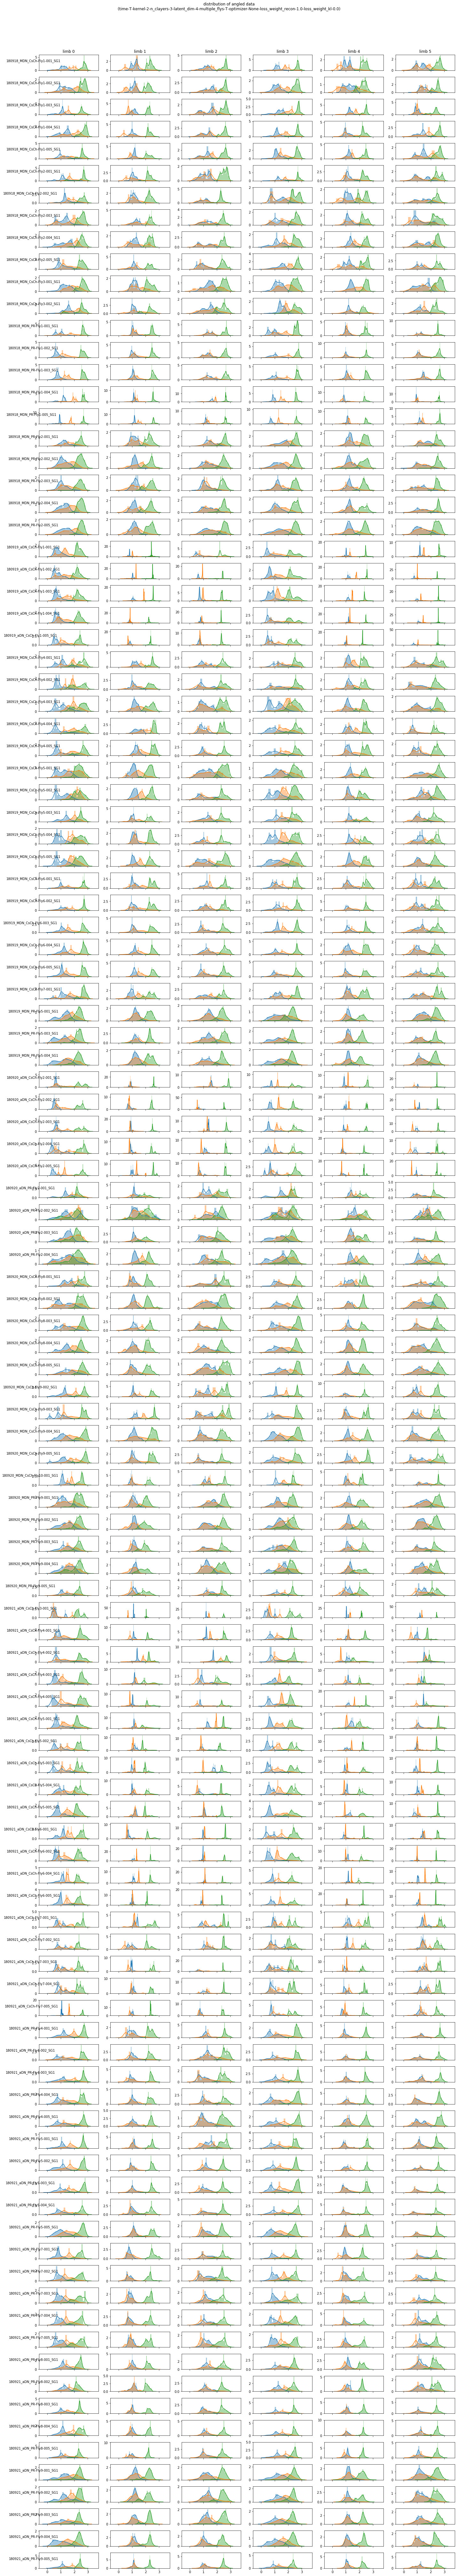

In [11]:
reload(plots)
plots.plot_distribution_of_angle_data(angle_data_raw, run_config=run_config);

In [12]:
#all_experiments = experiments_from_root()
#print(len(all_experiments))
#
#pos_data = preprocessing.get_data_and_normalization(all_experiments, per_experiment=True)
#
#norm_pos_data, norm_pos_data_params = zip(*[preprocessing.normalize(p) for p in pos_data])
#experiment_lengths = [len(p) for p in norm_pos_data] # for applying the right normalization factors
#norm_pos_data = np.vstack(norm_pos_data)
#
#print(f"in total we have {len(all_experiments)} experiments, but only {len(experiment_lengths)} are usable right now")
#
#norm_pos_data_embedded = TSNE(n_components=2, random_state=42).fit_transform(norm_pos_data[:, :, :2].reshape(norm_pos_data.shape[0], -1))
#
##_cs = sns.color_palette(n_colors=len(seen_labels))
##
##fig = plt.figure(figsize=(10, 10))
##_all_frames_ = pd.concat((training_frames, testing_frames))
##
##behaviour_colours = dict(zip(seen_labels, _cs))
##
##for l, c in behaviour_colours.items():
##    _d = X_embedded[_all_frames_['label'] == l]
##    # c=[c] since matplotlib asks for it
##    plt.scatter(_d[:, 0], _d[:,1], c=[c], label=l.name, marker='.')
##    
##plt.legend()
##plt.title('simple t-SNE on latent space')
##fig.savefig(f"../neural_clustering_data/figures/{som_vae_config['ex_name']}_tsne.png")
#
#_cs = sns.color_palette(n_colors=len(experiment_lengths))
#
#
#used_until = 0
#for i, l in enumerate(experiment_lengths):
#    plt.scatter(norm_pos_data_embedded[used_until:used_until+l, 0], norm_pos_data_embedded[used_until:used_until+l, 1], c=[_cs[i]])
#    used_until += l

In [13]:
joint_positions.shape

(102504, 18)

# preprocessing

In [14]:
def _to_time_series_(x):
    return np.array(list(misc.to_time_series(x, sequence_length=run_config['time_series_length'])))

def _prep_2d_pos_data_(x):
    return x[:,:,:2].reshape(x.shape[0], -1).astype(np.float32)

# scaling the data to be in [0, 1]
# this is due to the sigmoid activation function in the reconstruction (and because ANN train better with normalised data) (which it is not...)
scaler = MinMaxScaler()
scaler = StandardScaler()

#
# reshapping the data 
#

# TODO bring this in order!

if run_config['use_time_series']:
    # it's the shitty logical combination of these values
    # TODO the scaling should be learned on the training data only, but this is a bit tricky due to how we do the time-sequences
    # TODO right now the training and testing data are just concatenated time-sequences, experiment overlapping. which is bad.
    warnings.warn('this is not proper, fix the bugs here')
    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
        reshaped_joint_position = scaler.fit_transform(_prep_2d_pos_data_(joint_positions))
    else:
        reshaped_joint_position = scaler.fit_transform(joint_positions)
        
    reshaped_joint_position = _to_time_series_(reshaped_joint_position)
else:
    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
        # angle data is already flat
        reshaped_joint_position = _prep_2d_pos_data_(joint_positions)
    else:
        reshaped_joint_position = joint_positions

#
# debugging overwrite
#
    
if run_config['debug']:
    if run_config['d_zero_data']:
        # resetting the scaler to make our life easier down below the pipeline
        _dummy_data_ = np.zeros_like(joint_positions)
    elif run_config['d_sinoid_data']:
        if run_config['data_type'] == _DATA_TYPE_2D_POS_:
            _dummy_data_ = np.zeros_like(joint_positions)
            for frame in range(_dummy_data_.shape[0]):
                for joint in range(_dummy_data_.shape[1]):
                    _dummy_data_[frame, joint, :] = np.sin(2 * np.pi * frame/_dummy_data_.shape[0] + joint / _dummy_data_.shape[1])
                
        else:
            _dummy_data_ = np.array([[np.sin(x) + (offset / joint_positions.shape[1]) 
                                      for x in range(len(joint_positions))] 
                                     for offset in range(joint_positions.shape[1])]).T.astype(joint_positions.dtype)
            
            
    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
        _dummy_data_ = _prep_2d_pos_data_(_dummy_data_)
        
        
    if run_config['use_time_series']:
        reshaped_joint_position = scaler.fit_transform(_dummy_data_)
        reshaped_joint_position = _to_time_series_(reshaped_joint_position)
    else:
        reshaped_joint_position = _dummy_data_

#
# split and apply scaler
#

if reshaped_joint_position.shape[0] > 10**5:
    n_of_data_points = int(reshaped_joint_position.shape[0] * 0.9)
else:
    n_of_data_points = int(reshaped_joint_position.shape[0] * 0.7)

if run_config['use_time_series']:
    data_train = reshaped_joint_position[:n_of_data_points]
    data_test = reshaped_joint_position[n_of_data_points:]
    print('train')
    display.display(pd.DataFrame(data_train[:, -1, :]).describe())
    print('test')
    display.display(pd.DataFrame(data_test[:, -1, :]).describe())
else:
    data_train = scaler.fit_transform(reshaped_joint_position[:n_of_data_points])
    data_test = scaler.transform(reshaped_joint_position[n_of_data_points:])
    print('train')
    display.display(pd.DataFrame(data_train).describe())
    print('test')
    display.display(pd.DataFrame(data_test).describe())
    
print(f"shapes for train/test: {data_train.shape}, {data_test.shape}")

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: this is not proper, fix the bugs here


train


0             1             2             3             4   \
count  92245.000000  92245.000000  92245.000000  92245.000000  92245.000000   
mean      -0.015930     -0.005659      0.049353      0.008958      0.032319   
std        1.003181      1.013088      1.002765      1.005043      1.018819   
min       -2.480635     -2.774444     -7.180372     -4.261802     -2.674653   
25%       -0.838815     -0.724247     -0.534501     -0.626651     -0.744729   
50%       -0.066360      0.010489      0.203142     -0.034706     -0.097460   
75%        0.643821      0.706491      0.753216      0.571969      0.652053   
max        4.194888      2.895960      2.212582      8.400250      4.110773   

                 5             6             7             8             9   \
count  92245.000000  92245.000000  92245.000000  92245.000000  92245.000000   
mean       0.047362     -0.008338     -0.005836      0.020080     -0.029278   
std        1.006014      1.020139      1.010710      0.998971      1.004197   
min       -7.652940     -2.750048     -2.199535     -9.199269     -2.362958   
25%       -0.564337     -0.813907     -0.787501     -0.520846     -0.823869   
50%        0.187676     -0.085747     -0.113965      0.075137     -0.099331   
75%        0.763341      0.715562      0.659891      0.679717      0.655299   
max        2.936078      4.054767      3.219079      2.615829      4.342937   

                 10            11            12            13            14  \
count  92245.000000  92245.000000  92245.000000  92245.000000  92245.000000   
mean      -0.011241      0.040862      0.001988      0.041090      0.055839   
std        1.011640      1.008103      1.017801      1.019799      0.999269   
min       -2.934711     -7.040666     -4.134993     -2.567387     -8.362176   
25%       -0.729584     -0.545732     -0.708990     -0.665990     -0.444986   
50%       -0.048393      0.200855     -0.030017     -0.102596      0.190339   
75%        0.711268      0.756306      0.619569      0.655582      0.737957   
max        3.019248      2.189927      5.581922      4.061135      3.025322   

                 15            16            17  
count  92245.000000  92245.000000  92245.000000  
mean      -0.013186      0.003657      0.015601  
std        1.010227      1.007223      1.005133  
min       -3.041553     -2.208930     -7.397928  
25%       -0.757860     -0.712175     -0.383093  
50%       -0.134137     -0.108319      0.122063  
75%        0.663374      0.633322      0.615366  
max        3.553485      3.519162      2.503959

test


0             1             2             3             4   \
count  10250.000000  10250.000000  10250.000000  10250.000000  10250.000000   
mean       0.143008      0.050446     -0.444846     -0.081622     -0.291126   
std        0.959607      0.872262      0.854897      0.949493      0.751585   
min       -2.476987     -2.611748     -6.994029     -2.601577     -2.326997   
25%       -0.444679     -0.536738     -0.816278     -0.696183     -0.766939   
50%        0.122049      0.050709     -0.312211     -0.111392     -0.403588   
75%        0.694869      0.654762      0.067704      0.472367      0.095129   
max        3.760775      2.542008      1.908957      8.907636      3.934254   

                 5             6             7             8             9   \
count  10250.000000  10250.000000  10250.000000  10250.000000  10250.000000   
mean      -0.426230      0.074703      0.052102     -0.181288      0.262979   
std        0.831032      0.792822      0.896673      0.991309      0.920969   
min       -7.055556     -2.242275     -2.051530     -7.662493     -2.243876   
25%       -0.796270     -0.520974     -0.607059     -0.662380     -0.329699   
50%       -0.283021     -0.051402     -0.098185     -0.126309      0.215336   
75%        0.115244      0.578881      0.585466      0.406393      0.878720   
max        2.820361      2.978521      3.221172      2.450902      3.943787   

                 10            11            12            13            14  \
count  10250.000000  10250.000000  10250.000000  10250.000000  10250.000000   
mean       0.100371     -0.368556     -0.016914     -0.368005     -0.501791   
std        0.882264      0.838437      0.822395      0.697772      0.856577   
min       -2.864857     -6.497557     -2.665587     -2.447130     -7.962562   
25%       -0.498078     -0.717700     -0.534954     -0.842133     -0.885195   
50%        0.115240     -0.188466     -0.049957     -0.472114     -0.328624   
75%        0.728992      0.162879      0.434218     -0.002097      0.030411   
max        2.826667      2.130271      5.269996      3.275885      2.684286   

                 15            16            17  
count  10250.000000  10250.000000  10250.000000  
mean       0.119188     -0.032231     -0.140317  
std        0.894394      0.932142      0.941560  
min       -2.256212     -2.301137     -5.152270  
25%       -0.471965     -0.735982     -0.646027  
50%        0.026515     -0.178006     -0.075194  
75%        0.679979      0.557152      0.430650  
max        3.581894      3.023844      2.482366

shapes for train/test: (92245, 10, 18), (10250, 10, 18)


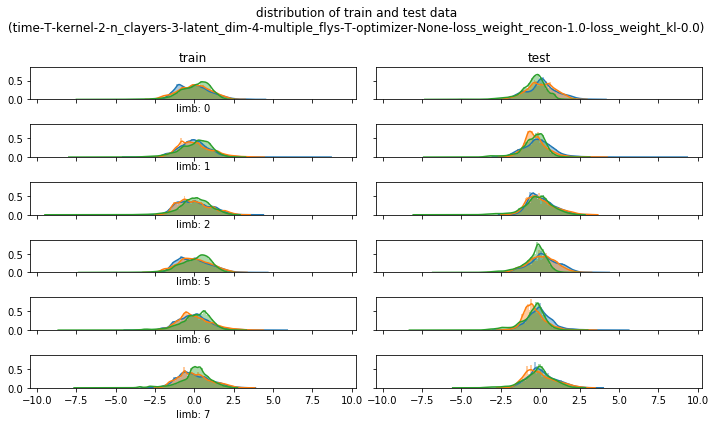

In [15]:
reload(plots)
#
# Making sure that the train/test distributions are not too different from each other
#
if run_config['use_time_series']:
    _plt_data_idx_ = np.s_[:, -1, :]
else:
    _plt_data_idx_ = np.s_[:]
    
if run_config['data_type'] == _DATA_TYPE_3D_ANGLE_:
    fig = plots.plot_3d_angle_data_distribution(data_train[_plt_data_idx_], data_test[_plt_data_idx_], selected_cols, exp_desc=config.config_description(run_config))
else:
    fig = plots.plot_2d_distribution(data_train[_plt_data_idx_], data_test[_plt_data_idx_], exp_desc=config.config_description(run_config))

## Use *tf.data* to create batches and shuffle the dataset

In [16]:
def to_tf_data(X):
    return tf.data.Dataset.from_tensor_slices(X).shuffle(len(X)).batch(run_config['batch_size'])

train_dataset = to_tf_data(data_train)
test_dataset = to_tf_data(data_test) 

# model def

## doc

### Sources:

- https://blog.keras.io/building-autoencoders-in-keras.html (keras autoencoder implementation)
- https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-3-7f6633fcc7c7 (temporal block)
- https://stackoverflow.com/questions/46503816/keras-conv1d-layer-parameters-filters-and-kernel-size (refresher on conv layers)
- https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d (refresher on conv layers)
- https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_conv/ (for a good overview over diluted causal convolutions)
- https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf?gi=c5cb3c007035 (general reference)

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

The dilated convolution between signal $f$ and kernel $k$ and dilution factor $l$ is defined as:

$$\left(k \ast_{l} f\right)_t = \sum_{\tau=-\infty}^{\infty} k_\tau \cdot f_{t - l\tau}$$

![](./figures/diluted_convolution.png)
![](./figures/WaveNet_gif.gif)

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

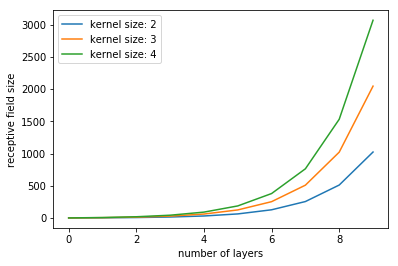

In [17]:
def _receptive_field_size_temporal_conv_net_(kernel_size, n_layers):
    return 1 + 2 * (kernel_size - 1) * (2 ** n_layers - 1)

for k in range(2, 5):
    plt.plot([_receptive_field_size_temporal_conv_net_(kernel_size=k, n_layers=n) for n in range(10)], label=f"kernel size: {k}")
plt.xlabel('number of layers')
plt.ylabel('receptive field size')
plt.legend()

## code

In [18]:
class TemporalBlock(tfkl.Layer):
    def __init__(self, filter_size, kernel_size, dilation_rate, dropout=0.2, trainable=True, name=None, dtype=None, activity_regularizer=None, **kwargs):
        """
        In the dilated convolution, the kernel only touches the signal at every lth entry 
        See https://www.inference.vc/dilated-convolutions-and-kronecker-factorisation/ (some bugs fixed and code adapted to our use case)
        """
        super(TemporalBlock, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs)        
        self.dropout = dropout
        self.filter_size = filter_size
        causal_conv_args = {"padding": "causal",
                            "dilation_rate": dilation_rate, 
                            "activation": tf.nn.leaky_relu}
        self.conv1 = tfkl.Conv1D(filter_size, kernel_size, **causal_conv_args, name="conv1")
        self.conv2 = tfkl.Conv1D(filter_size, kernel_size, **causal_conv_args, name="conv2")
        self.down_sample = None

    
    def build(self, input_shape):
        channel_dim = -1
        # SpatialDropout1D proved to be much better. Original paper: https://arxiv.org/abs/1411.4280
        self.dropout1 = tfkl.SpatialDropout1D(self.dropout)
        self.dropout2 = tfkl.SpatialDropout1D(self.dropout)
        if input_shape[channel_dim] != self.filter_size:
            # TODO why not a conv1d layer?
            # self.down_sample = tf.layers.Conv1D(
            #     self.filter_size, kernel_size=1, 
            #     activation=None, data_format="channels_last", padding="valid")
            self.down_sample = tfkl.Dense(self.filter_size, activation=None)
        self.built = True
    
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = self.dropout2(x, training=training)
        if self.down_sample is not None:
            inputs = self.down_sample(inputs)
        return tf.nn.relu(x + inputs)

In [19]:
# build using:
#   - https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/contrib/eager/python/examples/generative_examples/cvae.ipynb 
#   - https://www.kaggle.com/hone5com/fraud-detection-with-variational-autoencoder

def if_last(ls):
    for i, x in enumerate(ls):
        yield i, i + 1 == len(ls), x

def dense_layers(sizes, activation_fn=tf.nn.leaky_relu, name_prefix=None):
    # no activation in the last layer, because either it is 
    # a) the decoder/generative-layer which will apply a sigmoid activation function itself, or 
    # b) the encoder/inference-layer which does not need a activation function because ...??? TODO find a reason for this
    
    return [tfkl.Dense(size, activation=None if is_last else activation_fn, name=f"{name_prefix}_dense_{idx}") for idx, is_last, size in if_last(sizes)]

def temporal_layers(filter_sizes, kernel_size=2, dropout=0.2):
    return [TemporalBlock(filter_size, kernel_size, dilation_rate=2 ** i, dropout=dropout, name=f"temporal_block_{i}") for i, filter_size in enumerate(filter_sizes)]

class DrosophVAE(tf.keras.Model):
    def __init__(self, latent_dim, input_shape, batch_size, 
                 n_layers=3, dropout_rate_temporal=0.2, loss_weight_reconstruction=1.0, loss_weight_kl=1.0, filters_conv_layer=None, conv_layer_kernel_size=2):
        """
        Args:
        -----
        
        latent_dim              int, dimension of latent space
        input_shape             tuple, total input shape is: [batch_size, *input_shape]
        batch_size              int
        n_layers                int, number of dense layers. 
                                output shape of the dense layers is linearly scaled.
        dropout_rate_temporal   float, in [0, 1). dropout rate for temporal blocks (conv layers).
        filters_conv_layer      list[int]. filter sizes for conv layers
        """
        super(DrosophVAE, self).__init__()
        self.latent_dim = latent_dim
        self._input_shape = input_shape
        self._batch_size = batch_size
        self._loss_weight_reconstruction = loss_weight_reconstruction
        self._loss_weight_kl = loss_weight_kl
        self._layer_sizes_inference  = np.linspace(input_shape[-1], 2 * latent_dim, n_layers).astype(np.int)
        # pseudo reverse as the inference network goes down to double the latent space, ask Semigh about this
        # the 2 * n_layers is to keep compression speed roughly the same
        self._layer_sizes_generative = np.linspace(latent_dim, input_shape[-1], 2 * n_layers).astype(np.int).tolist()
        self._conv_layer_kernel_size = conv_layer_kernel_size
        
        self.inference_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape[-1]),
                                                 *dense_layers(self._layer_sizes_inference, name_prefix='inf')],
                                                 name='inference_net')

        self.generative_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                                                  *dense_layers(self._layer_sizes_generative, name_prefix='gen')],
                                                  name='generative_net')
        
        if len(input_shape) == 1:
            self.temporal_conv_net = None
        elif len(input_shape) == 2:
            # Remember that we do diluted convolutions -> The filter size can stay ~ constant. TODO discuss with Semigh
            if filters_conv_layer is None:
                # TODO this is probably not correct
                self.filters_conv_layer = [input_shape[-1]] * 3
            else:
                self.filters_conv_layer = filters_conv_layer
                
            self.temporal_conv_net = tfk.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape),
                                                     *temporal_layers(kernel_size=self._conv_layer_kernel_size, 
                                                                      filter_sizes=self.filters_conv_layer,  
                                                                      dropout=dropout_rate_temporal)],
                                                     name='temporal_conv_net')
            
            self.inference_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape),
                                                     *dense_layers(self._layer_sizes_inference, name_prefix='inf')],
                                                     name='inference_net')
        
            self.generative_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=list(input_shape[:1]) + [latent_dim]),
                                                      *dense_layers(self._layer_sizes_generative, name_prefix='gen')],
                                                      name='generative_net')
        else:
            raise ValueError(f"Input shape is not good, got: {input_shape}")
            
        print(self._config_())
    
    def sample(self, eps=None):
        if eps is None:
            if self._loss_weight_kl == 0.0:
                warnings.warn('KL loss is 0.0. The latent space is not properly trained')
            # The KL-loss is calculated against a normal distribution, 
            # thus it should resemble one and thus sampling should make sense.
            #eps = tf.random_normal(shape=(self._batch_size, self.latent_dim))
            eps = tf.random_normal(shape=[self._batch_size] + list(self.generative_net.input_shape[1:]))
        return self.decode(eps, apply_sigmoid=False)
  
    def encode(self, x, training=False):
        if self.temporal_conv_net:
            # TODO combine them into one? max pooling or something
            #x_tmp = tfkl.Lambda(lambda x: x[:, -1, :])(self.temporal_conv_net(x, training=training))
            mean, logvar = tf.split(self.inference_net(self.temporal_conv_net(x, training=training)), 
                                    num_or_size_splits=2,
                                    axis=-1)
        else:
            mean, logvar = tf.split(self.inference_net(x),
                                    num_or_size_splits=2,
                                    axis=1)
        return mean, logvar
  
    def reparameterize(self, mean, logvar):
        # TODO check: the params should be correct? check original paper
        eps = tf.random_normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
  
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
  
        return logits

    def predict(self, x):
        # https://github.com/LynnHo/VAE-Tensorflow/blob/master/train.py
        # epsilon = tf.random_normal(tf.shape(z_mu))
        # if is_training:
        #     z = z_mu + tf.exp(0.5 * z_log_sigma_sq) * epsilon
        # else:
        #     z = z_mu
        mean, logvar = self.encode(x)
        z = model.reparameterize(mean, logvar)
        return model.decode(z, apply_sigmoid=True)
    
    def call(self, x, training=False, apply_sigmoid=False):
        return self.decode(self.reparameterize(*self.encode(x, training=training)), 
                           apply_sigmoid=apply_sigmoid)
    
    def _config_(self):
        return {
            "latent_dim": self.latent_dim,
            "input_shape": self._input_shape,
            "batch_size": self._batch_size,
            "layer_sizes_inference": self._layer_sizes_inference,
            "layer_sizes_generative": self._layer_sizes_generative,
            "loss_weight_reconstruction": self._loss_weight_reconstruction,
            "loss_weight_kl": self._loss_weight_kl,
        }

In [20]:
if run_config['use_time_series']:
    assert len(data_train.shape) == 3, 'run all the necessary code, shape does not align with config'
else:
    assert len(data_train.shape) == 2, 'run all the necessary code, shape does not align with config'

In [21]:
data_test.shape

(10250, 10, 18)

In [22]:
# For the loss function:
#
# https://github.com/pytorch/examples/issues/399
#   Argues that since we are using a normal distribution we should not use any activation function in the last layer
#   and the loss should be MSE.
# https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder?rq=1
#   Some general discussion about KL vs recon-loss
# https://stats.stackexchange.com/questions/368001/is-the-output-of-a-variational-autoencoder-meant-to-be-a-distribution-that-can-b
    

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x, detailed=False, kl_nan_offset=1e-18):
    """
    Args:
    
        model          the model
        x              the data
        detailed       set to true if you want the losses to be returned as well
        kl_nan_offset  the kicker, can lead to NaN errors otherwise (don't ask me how long it took to find this)
                       value was found empirically 
    """
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    #if run_config['use_time_series']:
    #    # Note, the model is trained to reconstruct only the last, most current time step (by taking the last entry in the timeseries)
    #    # this works on classification data (or binary data)
    #    #cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x[:, -1, :])
    #    recon_loss = tf.losses.mean_squared_error(predictions=x_logit, labels=x[:, -1, :])
    #else:
    #    recon_loss = tf.losses.mean_squared_error(predictions=x_logit, labels=x)

    recon_loss = tf.losses.mean_squared_error(predictions=x_logit, labels=x)
    
    p = tfp.distributions.Normal(loc=tf.zeros_like(mean), scale=tf.ones_like(logvar))
    q = tfp.distributions.Normal(loc=mean + tf.constant(kl_nan_offset), scale=logvar + tf.constant(kl_nan_offset))
    kl = tf.reduce_mean(tfp.distributions.kl_divergence(p, q, allow_nan_stats=False))
    kl = tf.clip_by_value(kl, 0., 1.)
    
    if model._loss_weight_kl == 0.:
        loss = model._loss_weight_reconstruction*recon_loss 
    else:
        loss = model._loss_weight_reconstruction*recon_loss + model._loss_weight_kl*kl
    
    if detailed:
        return loss, recon_loss, kl
    else:
        return loss
    
    # TODO check this!
    # reconstruction loss
    #logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    #logpx_z = -tf.reduce_sum(cross_ent, axis=[1]) # down to [batch, loss]
    # KL loss
    logpz = log_normal_pdf(z, 0., 0.) # shouldn't it be `logvar = 0.0001` or something small?
    logqz_x = log_normal_pdf(z, mean, logvar)
    #return -tf.reduce_mean(model._loss_weight_reconstruction*logpx_z + model._loss_weight_kl*(logpz - logqz_x))

def compute_gradients(model, x): 
    with tf.GradientTape() as tape: 
        loss = compute_loss(model, x) 
        return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables, global_step=None):
    # TODO try out gradient clipping
    #gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
    optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

## training

In [23]:
# This is the init cell. The model and all related objects are created here.
if run_config['debug'] and run_config['d_no_compression']:
    latent_dim= data_train.shape[-1]
else:
    latent_dim = run_config['latent_dim'] # 2

tf.reset_default_graph()
test_reports = []
train_reports = []

run_config['loss_weight_reconstruction'] = 1.0
run_config['loss_weight_kl'] = 0. # 1e-3

model = DrosophVAE(latent_dim, 
                   input_shape=data_train.shape[1:], 
                   batch_size=run_config['batch_size'], 
                   n_layers=run_config['n_conv_layers'], 
                   dropout_rate_temporal=0.2,
                   loss_weight_reconstruction=run_config['loss_weight_reconstruction'],
                   loss_weight_kl=run_config['loss_weight_kl'])

if run_config['use_time_series']:
    model.temporal_conv_net.summary()
    
model.inference_net.summary()
model.generative_net.summary()

optimizer = tf.train.AdamOptimizer(1e-4)
#optimizer = tf.train.AdadeltaOptimizer(1e-4)
run_config['optimizer'] = optimizer._name
_config_hash_ = config.get_config_hash(run_config)
_base_path_ = f"{settings.config.__DATA_ROOT__}/tvae_logs/{config.config_description(run_config, short=True)}_{_config_hash_}"
train_summary_writer = tfc.summary.create_file_writer(_base_path_ + '/train')
test_summary_writer = tfc.summary.create_file_writer(_base_path_ + '/test')
#gradients_writer = tfc.summary.create_file_writer(_base_path_ + '/gradients')

/home/samuel/.conda/envs/tf_nightly/lib/python3.7/site-packages/tensorflow/python/eager/execution_callbacks.py:174: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(numpy_dtype, np.complex) or


{'latent_dim': 4, 'input_shape': (10, 18), 'batch_size': 1000, 'layer_sizes_inference': array([18, 13,  8]), 'layer_sizes_generative': ListWrapper([4, 6, 9, 12, 15, 18]), 'loss_weight_reconstruction': 1.0, 'loss_weight_kl': 0.0}
Model: "temporal_conv_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
temporal_block_0 (TemporalBl (None, 10, 18)            1332      
_________________________________________________________________
temporal_block_1 (TemporalBl (None, 10, 18)            1332      
_________________________________________________________________
temporal_block_2 (TemporalBl (None, 10, 18)            1332      
Total params: 3,996
Trainable params: 3,996
Non-trainable params: 0
_________________________________________________________________
Model: "inference_net"
_________________________________________________________________
Layer (type)                 Output Shape              Para

In [ ]:
# TODO for later
#from keras.utils import plot_model
#plot_model(model)

In [ ]:
# This is the run cell. Designed to be able to train the model for an arbitrary amount of epochs.
def _compute_loss_for_data_(model, data):
    loss = tfe.metrics.Mean()
    recon = tfe.metrics.Mean()
    kl = tfe.metrics.Mean()
    for batch in data:
        loss_b, recon_b, kl_b  = compute_loss(model, batch, detailed=True)
        loss(loss_b)
        recon(recon_b)
        kl(kl_b)
        
    total_loss = loss.result()
    total_recon = recon.result()
    total_kl = kl.result()
    
    return total_loss, total_recon, total_kl

def _progress_str_(epoch, train_reports, test_reports, time=None, stopped=False):
    progress_str = f"Epoch: {epoch:0>4}, train/test loss: {train_reports[-1][0]:0.3f}\t {test_reports[-1][0]:0.3f}"
    if time:
        progress_str += f" took {time:0.3f} sec"
        
    if stopped:
        progress_str = "Stopped training during " + progress_str
        
    return progress_str


print(f"will train model {model._config_()}, with global params: {run_config}, hash: {_config_hash_}")
print(f"will train for ever...")
epoch = len(train_reports)
while True:
    try:
        start_time = time.time()
        for train_x in train_dataset:
            gradients, loss = compute_gradients(model, train_x)
            apply_gradients(optimizer, gradients, model.trainable_variables)
        end_time = time.time()
        
        test_reports += [_compute_loss_for_data_(model, test_dataset)]
        train_reports += [_compute_loss_for_data_(model, train_dataset)]
        
        _recorded_scalars_ =  ['loss', 'recon', 'kl']
        tf_helpers.tf_write_scalars(train_summary_writer, zip(_recorded_scalars_, train_reports[-1]), step=epoch)
        tf_helpers.tf_write_scalars(test_summary_writer, zip(_recorded_scalars_, test_reports[-1]), step=epoch)
        
        with train_summary_writer.as_default(), tfc.summary.always_record_summaries():
            for g, var_name in zip(gradients, [tf_helpers.tf_clean_variable_name(v.name) for v in model.trainable_variables]):
                tfc.summary.histogram(f'gradient_{var_name}', g, step=epoch)
              
        if epoch % 10 == 0:
            print(_progress_str_(epoch, train_reports, test_reports, time=end_time - start_time))
            tfc.summary.flush()
        else:
            # simple "loading bar"
            print('=' * (epoch % 10) + '.' * (10 - (epoch % 10)), end='\r')

        epoch += 1
        
        #if epoch >= 100:
        #    warnings.warn('artifical break')
        #    break
    except KeyboardInterrupt:
        tfc.summary.flush()
        print(_progress_str_(epoch, train_reports, test_reports, stopped=True))
        break
        
train_reports = np.array(train_reports)
test_reports = np.array(test_reports)

train_losses = train_reports[:, 0]
test_losses = test_reports[:, 0]

#warnings.filterwarnings("ignore",category=FutureWarning)

In [ ]:
x = train_x
mean, logvar = model.encode(x)
z = model.reparameterize(mean, logvar)
x_logit = model.decode(z)

#if run_config['use_time_series']:
#    # Note, the model is trained to reconstruct only the last, most current time step (by taking the last entry in the timeseries)
#    # this works on classification data (or binary data)
#    #cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x[:, -1, :])
#    recon_loss = tf.losses.mean_squared_error(predictions=x_logit, labels=x[:, -1, :])
#else:
#    recon_loss = tf.losses.mean_squared_error(predictions=x_logit, labels=x)

recon_loss = tf.losses.mean_squared_error(predictions=x_logit, labels=x)

offset = 1.
while True:
    print(offset)
    p = tfp.distributions.Normal(loc=tf.zeros_like(mean), scale=tf.ones_like(logvar))
    q = tfp.distributions.Normal(loc=mean + tf.constant(offset), scale=logvar + tf.constant(offset))
    kl = tf.reduce_mean(tfp.distributions.kl_divergence(p, q, allow_nan_stats=False))
    
    offset /= 10

1.0
0.1
0.01
0.001
0.0001
1e-05
1.0000000000000002e-06
1.0000000000000002e-07
1.0000000000000002e-08
1.0000000000000003e-09
1.0000000000000003e-10
1.0000000000000003e-11
1.0000000000000002e-12
1.0000000000000002e-13
1.0000000000000002e-14
1e-15
1.0000000000000001e-16
1e-17
1e-18
1.0000000000000001e-19
1.0000000000000001e-20
1.0000000000000001e-21
1e-22
1.0000000000000001e-23
1.0000000000000001e-24
1.0000000000000002e-25
1.0000000000000002e-26
1.0000000000000002e-27
1.0000000000000002e-28
1.0000000000000002e-29
1.0000000000000003e-30
1.0000000000000003e-31
1.0000000000000003e-32
1.0000000000000004e-33
1.0000000000000004e-34
1.0000000000000004e-35
1.0000000000000004e-36
1.0000000000000005e-37
1.0000000000000005e-38
1.0000000000000004e-39
1.0000000000000003e-40
1.0000000000000004e-41
1.0000000000000004e-42
1.0000000000000003e-43
1.0000000000000003e-44
1.0000000000000003e-45
1.0000000000000002e-46
1.0000000000000002e-47
1.0000000000000003e-48
1.0000000000000003e-49
1.0000000000000004e-50
1

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
np.isnan(logvar.numpy()).sum()

In [ ]:
np.isnan(mean.numpy()).sum()

In [ ]:

p = tfp.distributions.Normal(loc=tf.zeros_like(mean) + tf.constant(1e-8), scale=tf.ones_like(logvar) + tf.constant(1e-8))
q = tfp.distributions.Normal(loc=mean, scale=logvar)

In [ ]:
def kl_divergence(p, q):
    return tf.reduce_sum(p * tf.log(p/q))

In [ ]:
tfp.distributions.kl_divergence(q, q, allow_nan_stats=False)

# evaluation

In [ ]:
def _reverse_to_original_shape_(X):
    rescaled = scaler.inverse_transform(X)
    if run_config['data_type'] == _DATA_TYPE_2D_POS_:
        return rescaled.reshape(-1, 15, 2)
    else:
        return rescaled

In [ ]:
exp_desc = config.exp_desc(run_config, {**model._config_(), 'epochs': len(train_losses)})
exp_desc_short = config.exp_desc(run_config, {**model._config_(), 'epochs': len(train_losses)}, short=True)
input_data_raw = np.vstack((data_train, data_test))

if run_config['use_time_series']:
    input_data = _reverse_to_original_shape_(input_data_raw[:, -1, :])
else:
    input_data = _reverse_to_original_shape_(input_data_raw)
    
if run_config['use_time_series']:
    reconstructed_data = _reverse_to_original_shape_(model(input_data_raw, apply_sigmoid=False).numpy()[:, -1, :])
else:
    reconstructed_data = _reverse_to_original_shape_(model(input_data_raw, apply_sigmoid=False).numpy())
    
_min_nb_batches_for_sample_length_ = int(np.ceil(len(input_data_raw) / run_config['batch_size'] / run_config['time_series_length']))
generated_data = _reverse_to_original_shape_(np.vstack([model.sample().numpy() for _ in range(_min_nb_batches_for_sample_length_)]))[:len(reconstructed_data)]

In [ ]:
for a, n in zip(range(train_reports.shape[1]), _recorded_scalars_):
    plt.subplot(train_reports.shape[1], 1, a + 1)
    plt.plot(train_reports[:, a], label=f"train_{n}")
    plt.plot(test_reports[:, a], label=f"test_{n}")
    plt.title(n)
    
plt.tight_layout()
plt.legend()

In [ ]:
#plots.plot_losses(train_losses, test_losses, exp_desc=exp_desc);

In [ ]:
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    fig = plots.plot_comparing_joint_position_with_reconstructed(input_data, reconstructed_data, generated_data, validation_cut_off=len(data_train), exp_desc=exp_desc);
else:
    fig, axs = plt.subplots(nrows=len(selected_cols), ncols=3, figsize=(30, 20), sharex=True, sharey=True)
    start = 100
    end = 300
    xticks = np.arange(start, end)
    for i, c in enumerate(selected_cols):
        _idx_ = np.s_[start:end, i]
        axs[i][0].plot(xticks, input_data[_idx_])
        axs[i][1].plot(xticks, reconstructed_data[_idx_])
        axs[i][2].plot(xticks, generated_data[_idx_])
        
        #for a in axs[i]:
        #    a.axvline(len(data_train), label='validation cut off', linestyle='--')

    axs[0][0].set_title('input')
    axs[0][1].set_title('reconstructed')
    axs[0][2].set_title('generated')
    for i in range(3):
        axs[-1][i].set_xlabel('time step')
    
    plt.suptitle(f"Comparision of selection of data\n({exp_desc})")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    #plt.savefig(f"./figures/{_CONFIG_HASH_}_input_gen_recon_comparision.png")

# Latent space

In [ ]:
from hdbscan import HDBSCAN

In [ ]:
from collections import namedtuple
from sklearn.manifold import TSNE

LatentSpaceEncoding = namedtuple('LatentSpaceEncoding', 'mean var')

warnings.warn('should use all data `input_data`')
if run_config['use_all_experiments']:
    X_latent = LatentSpaceEncoding(*map(lambda x: x.numpy(), model.encode(input_data_raw[np.random.choice(len(input_data), 10000)])))
else:
    X_latent = LatentSpaceEncoding(*map(lambda x: x.numpy(), model.encode(input_data_raw)))
    
X_latent_mean_tsne_proj = TSNE(n_components=2, random_state=42).fit_transform(np.hstack((X_latent.mean, X_latent.var)))

In [ ]:
cluster_assignments = HDBSCAN(min_cluster_size=8).fit_predict(np.hstack((X_latent.mean, X_latent.var)))

In [ ]:
from matplotlib import gridspec

fig = plt.figure(figsize=(20, 18))
gs = gridspec.GridSpec(3, 2, figure=fig)
ax1 = plt.subplot(gs[:2, :])
ax2 = plt.subplot(gs[-1:, :1])
ax3 = plt.subplot(gs[-1:, 1:])

#plt.figure(figsize=(20, 12))
#fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))
for cluster in np.unique(cluster_assignments):
    c_idx = cluster_assignments == cluster
    c_idx = c_idx & (np.random.random(len(c_idx)) > 0.7) # don't show all of them, takes for ever otherwise
    sns.scatterplot(X_latent_mean_tsne_proj[c_idx, 0], X_latent_mean_tsne_proj[c_idx, 1], label=cluster, ax=ax1)
    sns.scatterplot(X_latent.mean[c_idx, 0], X_latent.mean[c_idx, 1], label=cluster, ax=ax2)
    sns.scatterplot(X_latent.var[c_idx, 0], X_latent.var[c_idx, 1], label=cluster, ax=ax3)
    
plt.legend()
ax1.set_title('T-SNE proejection of latent space (mean & var stacked)')
ax2.set_title('mean')
ax3.set_title('var');

# videos

In [ ]:
def reverse_pos_pipeline(x, normalisation_term=normalisation_factors):
    """TODO This is again pretty shitty... ultra hidden global variable"""
    return x + normalisation_term[:x.shape[-1]]

def video_prep_raw_data(data):
    if run_config['use_time_series']:
        return reverse_pos_pipeline(scaler.inverse_transform(data[:, -1, :]).reshape(-1, 15, 2))
    else:
        return reverse_pos_pipeline(scaler.inverse_transform(data.reshape(-1, 30)).reshape(-1, 15, 2))
    
def video_prep_recon_data(input_data):
    return reverse_pos_pipeline(scaler.inverse_transform(model(input_data).numpy()).reshape(-1, 15, 2))

In [ ]:
if run_config['data_type'] == _DATA_TYPE_2D_POS_:
    _positional_data_ = [reverse_pos_pipeline(input_data), reverse_pos_pipeline(reconstructed_data)]
else:
    raise NotImplementedError('give me a break')
    
p = video.comparision_video_of_reconstruction(_positional_data_,
                                              images_paths_for_experiments=images_paths_for_experiments, 
                                              n_train=len(data_train),
                                              cluster_assignments=cluster_assignments,
                                              as_frames=False,
                                              exp_desc=exp_desc_short)

display_video(p)

In [ ]:
from collections import OrderedDict
_N_CLUSTER_TO_VIZ_ = 10
_t = [(misc.flatten(sequences), cluster_id) for cluster_id, sequences in video.group_by_cluster(cluster_assignments).items()]
_t = sorted(_t, key=lambda x: len(x[0]), reverse=True)

cluster_colors = sns.color_palette(n_colors=len(np.unique(cluster_assignments)))

cluster_vids = OrderedDict((p[1], video.comparision_video_of_reconstruction(_positional_data_,
                                                                      cluster_assignments=cluster_assignments,
                                                                      images_paths_for_experiments=images_paths_for_experiments,
                                                                      n_train=data_train.shape[0],
                                                                      cluster_colors=cluster_colors,
                                                                      cluster_id_to_visualize=p[1], exp_desc=exp_desc))
                    for p in _t[:_N_CLUSTER_TO_VIZ_])

print('cluster_vids: ', cluster_vids.keys())

In [ ]:
c_idx = 0
#c_idx += 1
display_video(list(cluster_vids.values())[c_idx])